## Preamble

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from fastai.vision import *

## Downloading the Data

In [6]:
url = "http://www.josiahwang.com/dataset/leedsbutterfly/leedsbutterfly_dataset_v1.0.zip"
filename = "leedsbutterfly_dataset_v1.0.zip"

In [7]:
path = datapath4file(Path())
path

PosixPath('/home/paperspace/.fastai/data')

In [26]:
download_url(url, path/filename)

In [8]:
path.ls()

[PosixPath('/home/paperspace/.fastai/data/leedsbutterfly'),
 PosixPath('/home/paperspace/.fastai/data/leedsbutterfly_dataset_v1.0.zip')]

In [33]:
import zipfile
with zipfile.ZipFile(path/filename, 'r') as zip_ref:
    zip_ref.extractall(path)

In [6]:
path.ls()

[PosixPath('/home/paperspace/.fastai/data/leedsbutterfly'),
 PosixPath('/home/paperspace/.fastai/data/leedsbutterfly_dataset_v1.0.zip')]

In [9]:
path = path/"leedsbutterfly"
path.ls()

[PosixPath('/home/paperspace/.fastai/data/leedsbutterfly/cleaned.csv'),
 PosixPath('/home/paperspace/.fastai/data/leedsbutterfly/images'),
 PosixPath('/home/paperspace/.fastai/data/leedsbutterfly/descriptions'),
 PosixPath('/home/paperspace/.fastai/data/leedsbutterfly/segmentations'),
 PosixPath('/home/paperspace/.fastai/data/leedsbutterfly/README.txt')]

In [13]:
path_img = path/"images"
path_img.ls()

[PosixPath('/home/paperspace/.fastai/data/leedsbutterfly/images/001'),
 PosixPath('/home/paperspace/.fastai/data/leedsbutterfly/images/007'),
 PosixPath('/home/paperspace/.fastai/data/leedsbutterfly/images/004'),
 PosixPath('/home/paperspace/.fastai/data/leedsbutterfly/images/008'),
 PosixPath('/home/paperspace/.fastai/data/leedsbutterfly/images/006'),
 PosixPath('/home/paperspace/.fastai/data/leedsbutterfly/images/010'),
 PosixPath('/home/paperspace/.fastai/data/leedsbutterfly/images/models'),
 PosixPath('/home/paperspace/.fastai/data/leedsbutterfly/images/002'),
 PosixPath('/home/paperspace/.fastai/data/leedsbutterfly/images/009'),
 PosixPath('/home/paperspace/.fastai/data/leedsbutterfly/images/cleaned.csv.backup'),
 PosixPath('/home/paperspace/.fastai/data/leedsbutterfly/images/005'),
 PosixPath('/home/paperspace/.fastai/data/leedsbutterfly/images/003')]

In [14]:
np.random.seed(2)
pat = r'(\d{3})(\d+).png$'
bs = 32

In [19]:
data = (ImageList.from_folder(path_img)
                   .split_subsets(train_size=0.8,valid_size=0.2)
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

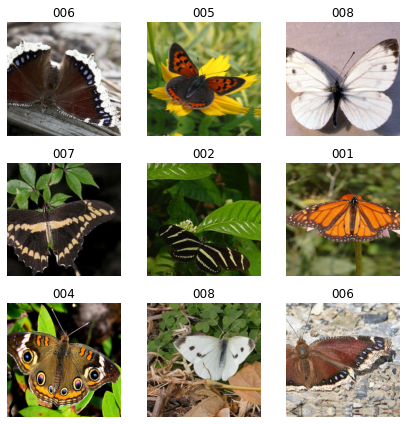

In [20]:
data.show_batch(rows=3, figsize=(6,6))

In [21]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['001', '002', '003', '004', '005', '006', '007', '008', '009', '010'],
 10,
 665,
 166)

## Training the Model

In [22]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
# learn.model

In [23]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.265332,0.419036,0.114458,00:43
1,1.112881,0.151628,0.054217,00:50
2,0.678451,0.062319,0.018072,00:46
3,0.468048,0.058215,0.006024,00:47


In [24]:
learn.save("stage-1")

## Finding a Better Learning Rate

In [25]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.085534,0.087922,0.024096,01:02


In [27]:
learn.load("stage-1")

Learner(data=ImageDataBunch;

Train: LabelList (665 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
005,008,006,007,004
Path: /home/paperspace/.fastai/data/leedsbutterfly/images;

Valid: LabelList (166 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
009,007,005,009,006
Path: /home/paperspace/.fastai/data/leedsbutterfly/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): Batc

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


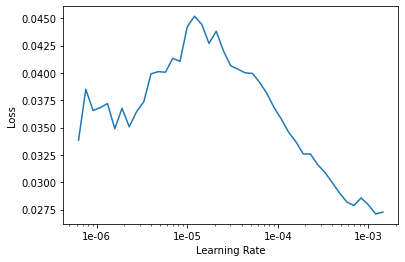

In [29]:
learn.recorder.plot()

In [30]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.045033,0.034161,0.006024,01:02
1,0.049411,0.010559,0.006024,01:12


In [31]:
learn.save("stage-2")

## Interpretation

In [32]:
learn.load("stage-2")

Learner(data=ImageDataBunch;

Train: LabelList (665 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
005,008,006,007,004
Path: /home/paperspace/.fastai/data/leedsbutterfly/images;

Valid: LabelList (166 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
009,007,005,009,006
Path: /home/paperspace/.fastai/data/leedsbutterfly/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): Batc

In [33]:
interp = ClassificationInterpretation.from_learner(learn)

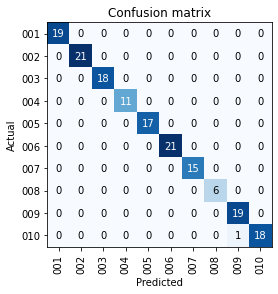

In [34]:
interp.plot_confusion_matrix()
# doc(ClassificationInterpretation.plot_confusion_matrix)

## Cleaning Up

In [46]:
import os, shutil

for f in fnames:
    label = str(f)[-11:-8]
    subdir = path_img/label
    if not os.path.exists(subdir):
        os.makedirs(subdir)
    shutil.move(str(f), subdir)

In [35]:
from fastai.widgets import *

In [36]:
db_clean = (ImageList.from_folder(path_img)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [37]:
learn_cln = cnn_learner(db_clean, models.resnet34, metrics=error_rate)

In [38]:
learn_cln.load("stage-2")

Learner(data=ImageDataBunch;

Train: LabelList (832 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
001,001,001,001,001
Path: /home/paperspace/.fastai/data/leedsbutterfly/images;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /home/paperspace/.fastai/data/leedsbutterfly/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (

In [39]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [40]:
ImageCleaner(ds, idxs, path_img)

'No images to show :)'

In [42]:
db_clean = (ImageList.from_csv(path_img, 'cleaned.csv', folder='.')
                   .split_none()
                   .label_from_df()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [43]:
learn_cln = cnn_learner(db_clean, models.resnet34, metrics=error_rate)

In [44]:
learn_cln.load("stage-2")

Learner(data=ImageDataBunch;

Train: LabelList (830 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,1,1,1
Path: /home/paperspace/.fastai/data/leedsbutterfly/images;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /home/paperspace/.fastai/data/leedsbutterfly/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Co

In [63]:
learn_cln.export(file = path/"export.pkl")

In [64]:
defaults.device = torch.device("cpu")

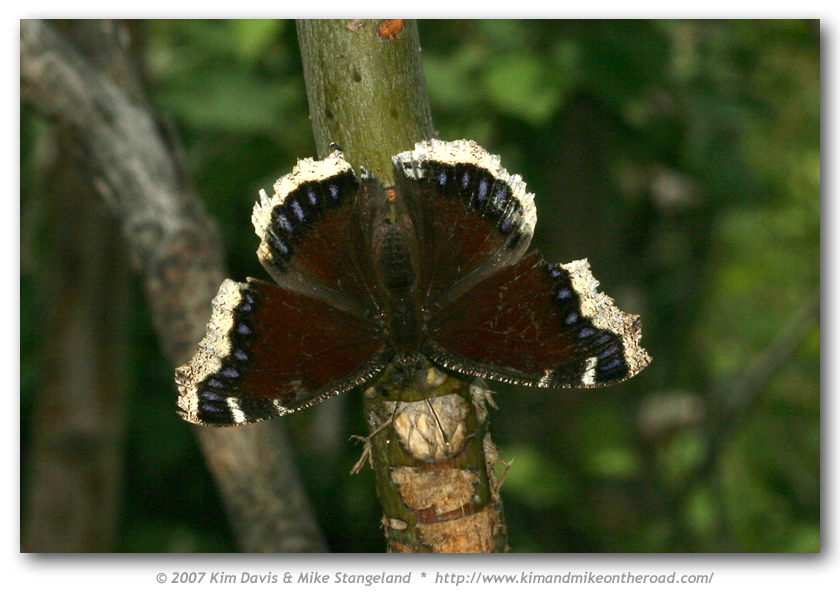

In [65]:
img = open_image(path_img/"006"/"0060007.png")
img

In [66]:
learn_cln = load_learner(path)

In [67]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class.obj

'006'